# Northwind DataBase Hypothesis Testing

### Company Schema

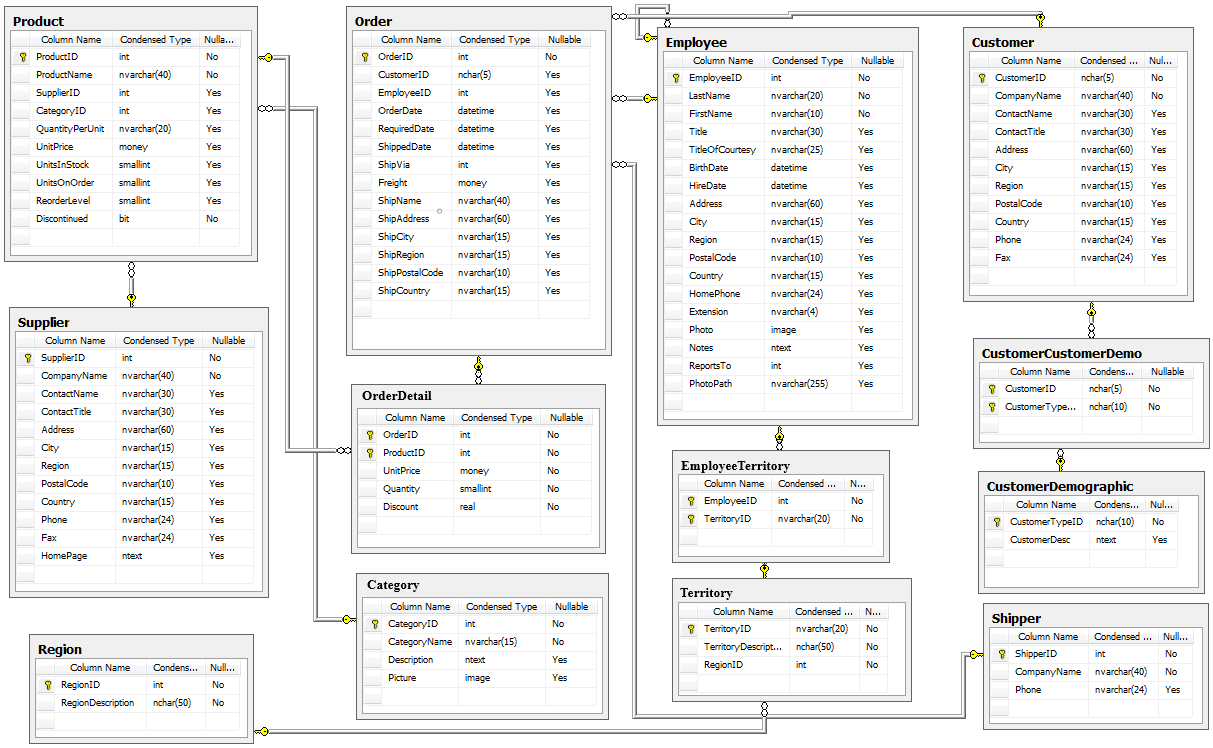

### Import Libraries 

In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from statsmodels.formula.api import ols
import statsmodels.api as sm

# Question 1 
Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

### Hypothesis

Null Hypothesis: Discount has no effect on the quantity of a product

Alternative Hypothesis: The quantity of a product in an order is increased by the discount at all different levels

### Connecting to the Northwind database

In [2]:
conn = sqlite3.connect("Northwind_small (1) (1).sqlite")
cur = conn.cursor()

In [3]:
#get table names
tables= cur.execute('''SELECT name FROM sqlite_master WHERE TYPE = "table"''').fetchall()
tables

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

In [4]:
#Let's zoom into the order detail table outline quantity and discount 
cur.execute("""SELECT * FROM OrderDetail""")
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


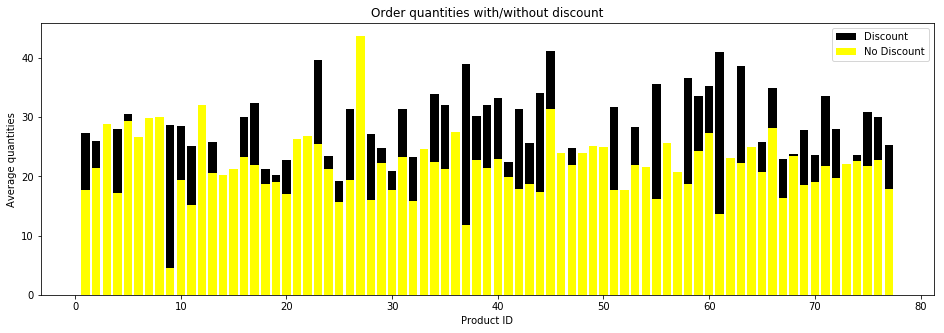

In [5]:
discount = df[df['Discount']!=0].groupby('ProductId')['Quantity'].mean()
no_discount = df[df['Discount']==0].groupby('ProductId')['Quantity'].mean()
plt.figure(figsize=(16,5))
plt.bar(discount.index, discount.values, alpha=1, label='Discount', color='black')
plt.bar(no_discount.index, no_discount.values, alpha=1, label='No Discount', color='yellow')
plt.legend()
plt.title('Order quantities with/without discount')
plt.xlabel('Product ID')
plt.ylabel('Average quantities')
plt.show()

Clear that there is a larger quantity of items ordered that were discounted.

Let's see at what levels these items appear to be most sold

In [6]:
df.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

Looks like .03,.02,.01,.04,.06 will be insignificant due to minimal values. Going to remove these.

In [7]:
dflevel = df[df.Discount.isin(['0.00', '0.05', '0.10', '0.15', '0.20', '0.25'])]

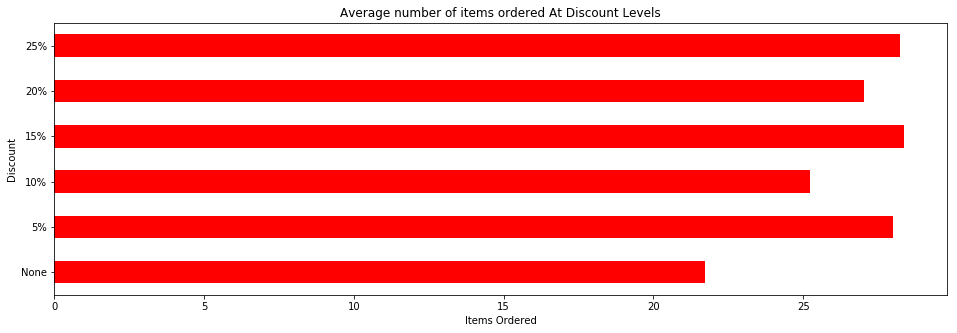

In [8]:
fig, ax = plt.subplots(1,1,figsize=(16,5)) 
y_ticks_labels = ['None', '5%', '10%', '15%', '20%', '25%']
dflevel.groupby(['Discount'])['Quantity'].mean().plot(kind='barh', color=['red'])
ax.set_ylabel('Discount')
ax.set_xlabel('Items Ordered')
ax.set_title('Average number of items ordered At Discount Levels')
ax.set_yticklabels(['None', '5%', '10%', '15%', '20%', '25%'])
fig.subplots_adjust(hspace=0.5);


### Welch's T Test

As seen above, there is a  difference in the sample sizes for no discount and discount. Since there is such a difference, we will perform a Welch's T Test. With a large population size we can ignore normality. 

This is a two sample t-test used to test the hypthosis that two populations have equal means

In [9]:
no_discount = df[df['Discount'] == 0.0]['Quantity'].values
no_discount.shape

(1317,)

In [10]:
discount = df[df['Discount'] != 0.0 ]['Quantity'].values
discount.shape

(838,)

Writing a function for the Welch's t-statistic

In [11]:
def welch_t(a, b):
    

    numerator = a.mean() - b.mean()
    
    # “ddof = Delta Degrees of Freedom”: the divisor used in the calculation is N - ddof, 
    #  where N represents the number of elements. By default ddof is zero.
    
    denominator = np.sqrt(a.var(ddof=1)/a.size + b.var(ddof=1)/b.size)
    
    return np.abs(numerator/denominator)

welch_t(discount, no_discount)

6.239069142123973

Calculating the degrees of freedown between the two samples

In [12]:
def welch_df(a, b):
        
    s1 = a.var(ddof=1) 
    s2 = b.var(ddof=1)
    n1 = a.size
    n2 = b.size
    
    numerator = (s1/n1 + s2/n2)**2
    denominator = (s1/ n1)**2/(n1 - 1) + (s2/ n2)**2/(n2 - 1)
    
    return numerator/denominator

welch_df(discount, no_discount)

1561.7678231942148

In [13]:
t = welch_t(discount, no_discount)
df_t = welch_df(discount, no_discount)
print(t,df_t)

6.239069142123973 1561.7678231942148


Converting to a p value

In [14]:
p = 1 - stats.t.cdf(t, df_t)
print(p)

2.8282065578366655e-10


Significantly below the alpha .05 threshold. We can REJECT THE NULL Hypothesis, and note that the quantities of the product are increased with items that are discounted

Now we want to figure out at what level there may be a difference

In [15]:
discounts = [0.05, 0.1, 0.15, 0.2, 0.25]
control = df[df['Discount']==0]['Quantity']
for i in discounts:
    experimental = df[df['Discount']==i]['Quantity']
    st, p = stats.ttest_ind(control, experimental)
    print(st, p)

-4.418557901446638 1.064949724167325e-05
-2.423258752228738 0.015500606526440095
-4.411192556207304 1.1027809944864872e-05
-3.6019486047561884 0.00032631258591041463
-4.304937285665697 1.780928988051903e-05


Result: Reject the Null Hypothesis as P-value is less than alpha = .05 threshold. There is a statistically significant difference in quantities between orders with no discount and specific discount levels. 

Business Reccomendation: Discount more for volume of products. If you purchase more in bulk, discount appropriately so you can sell that bulk

# Question 2

Does whether or not a product was regionally imported or domestically handled impact the discount of the order?


### Hypothesis
Null: There is no statistical significance between discounts and imported/domestic orders.
    
Alternative: There is a statiscal signifcance, and imported orders are sold with a greater discount

In [16]:
cur.execute("""SELECT C. ID, S.Region supplier_region, OD.Discount, C.Region customer_region
                            FROM Supplier S
                            JOIN Product P ON S.Id = P.SupplierId
                            JOIN OrderDetail OD ON P.Id = OD.ProductId
                            JOIN [Order] O ON OD.OrderId = O.Id
                            JOIN Customer C ON O.CustomerId = C.Id
                             """)
                               
df1 = pd.DataFrame(cur.fetchall())
df1.columns = [x[0] for x in cur.description]
df1.head()

,Id,supplier_region,Discount,customer_region
0,VINET,Southern Europe,0.0,Western Europe
1,VINET,South-East Asia,0.0,Western Europe
2,VINET,Southern Europe,0.0,Western Europe
3,TOMSP,Eastern Asia,0.0,Western Europe
4,TOMSP,NSW,0.0,Western Europe


In [17]:
df1['region_preference'] = np.where(df1['supplier_region'] == df1['customer_region'], 'domestic', 'imported')
df1['region_preference'].value_counts()

imported    1780
domestic     298
Name: region_preference, dtype: int64

In [18]:
df1['domestic_discount'] = np.where(df1['region_preference'] == 'domestic', df1['Discount'], 0.0)

df1['imported_discount'] = np.where(df1['region_preference'] == 'imported', df1['Discount'], 0.0)

df1.head()

,Id,supplier_region,Discount,customer_region,region_preference,domestic_discount,imported_discount
0,VINET,Southern Europe,0.0,Western Europe,imported,0.0,0.0
1,VINET,South-East Asia,0.0,Western Europe,imported,0.0,0.0
2,VINET,Southern Europe,0.0,Western Europe,imported,0.0,0.0
3,TOMSP,Eastern Asia,0.0,Western Europe,imported,0.0,0.0
4,TOMSP,NSW,0.0,Western Europe,imported,0.0,0.0


In [19]:
df1_test = df1[['customer_region', 'domestic_discount', 'imported_discount']]
df1_test = df1_test.groupby('customer_region').mean()
df1_test

,domestic_discount,imported_discount
customer_region,,
British Isles,0.005526,0.043684
Central America,0.000000,0.000000
Eastern Europe,0.000000,0.000000
North America,0.010468,0.049813
Northern Europe,0.006643,0.062937
Scandinavia,0.003571,0.025000
South America,0.002138,0.056414
Southern Europe,0.006934,0.047445
Western Europe,0.010054,0.049932


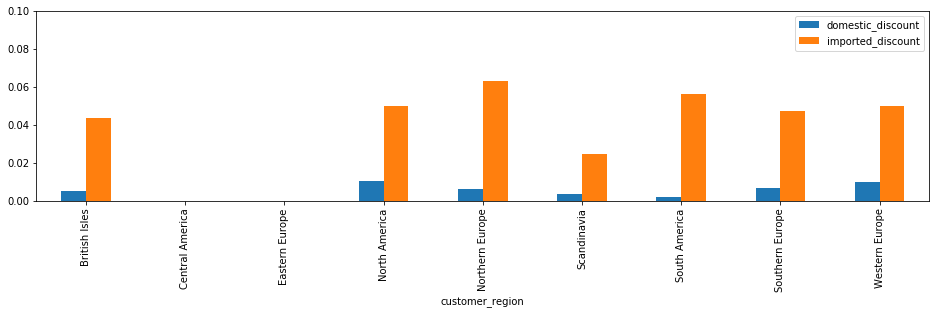

In [20]:
df1_test[['domestic_discount', 'imported_discount']].plot(kind='bar', ylim=(0, .1), figsize=(16,3.5));

### Welch's T-Test

Since there is a difference in the sample sizes for domestic and imported, we will perform a Welch's T Test. With a large population size we can ignore normality. 

This is a two sample t-test used to test the hypthosis that two populations have equal means

In [21]:
welch_t(df1_test['domestic_discount'],df1_test['imported_discount'])

4.056874764654556

In [22]:
welch_df(df1_test['domestic_discount'],df1_test['imported_discount'])

8.44306287759477

In [23]:
t_1 = welch_t(df1_test['domestic_discount'],df1_test['imported_discount'])
df_t1 = welch_df(df1_test['domestic_discount'],df1_test['imported_discount'])
print(t_1,df_t1)

4.056874764654556 8.44306287759477


In [24]:
p = 1 - stats.t.cdf(t_1, df_t1)
print(p)

0.0016303840962723637


Result: P Value is below alpha =.05 threshold. We can reject the null hypthosis. It is clear that imported orders statistically sell at higher discounts. 

Business Reccomendation: Imported orders likely have higher costs becuase it is more expensive to ship these items. Work with your team to discount these orders less than domestic. 

# Question 3

Do the volume of territories owned by an employer affect their order performance? 


### Hypothesis
Null: There is not statistical signifance between volume of territory and number of orders

Alternative: Employees with smaller territories will perform better than those with larger territories

In [25]:
cur.execute("""SELECT E.FirstName AS Employee_Name, COUNT(DISTINCT(ET.TerritoryId)) AS Territory_Size, COUNT(DISTINCT(O.Id)) as Total_Orders
                            FROM [Order] O
                            JOIN OrderDetail OD ON O.Id = OD. OrderId
                            JOIN Employee E ON O.EmployeeId = E.Id
                            JOIN EmployeeTerritory ET ON E.Id = ET.EmployeeId
                            GROUP BY E.FirstName
                             """)
                               
df2 = pd.DataFrame(cur.fetchall())
df2.columns = [x[0] for x in cur.description]
df2

,Employee_Name,Territory_Size,Total_Orders
0,Andrew,7,96
1,Anne,7,43
2,Janet,4,127
3,Laura,4,104
4,Margaret,3,156
5,Michael,5,67
6,Nancy,2,123
7,Robert,10,72
8,Steven,7,42


In [26]:
df2_test = df2[['Employee_Name', 'Territory_Size', 'Total_Orders']]
df2_test = df2_test.groupby('Employee_Name').mean()
df2_test

,Territory_Size,Total_Orders
Employee_Name,,
Andrew,7,96
Anne,7,43
Janet,4,127
Laura,4,104
Margaret,3,156
Michael,5,67
Nancy,2,123
Robert,10,72
Steven,7,42


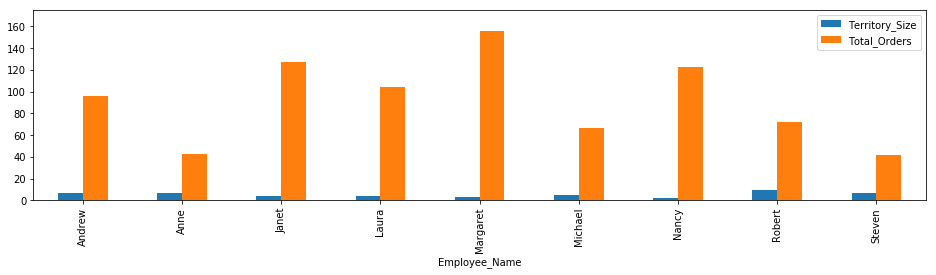

In [27]:
df2_test[['Territory_Size', 'Total_Orders']].plot(kind='bar', ylim=(0, 175), figsize=(16,3.5));

### Welch's T-Test

Since there is a difference in the sample sizes for domestic and imported, we will perform a Welch's T Test. With a large population size we can ignore normality. 

This is a two sample t-test used to test the hypthosis that two populations have equal means

In [28]:
welch_t(df2_test['Territory_Size'],df2_test['Total_Orders'])

6.607738245754705

In [29]:
welch_df(df2_test['Territory_Size'],df2_test['Total_Orders'])

8.064971796684315

In [30]:
t_2 = welch_t(df2_test['Territory_Size'],df2_test['Total_Orders'])
df_t2 = welch_df(df2_test['Territory_Size'],df2_test['Total_Orders'])
print(t_2,df_t2)

6.607738245754705 8.064971796684315


In [31]:
p = 1 - stats.t.cdf(t_2, df_t2)
print(p)

8.102312658875288e-05


Result: p-value under the alpha = .05 threshold. There is a statistical significance between volume of territory and number of total orders. 

Business reccomendation: May want to organize employees all with smaller, denser territories where they can have an expertise in the market and perform optimally. 

# Question 4

Do Countries with more customers have more total orders shipped?

### Hypothesis
Null Hypothesis: Number of Customers in a Country does not have an affect on total orders

Alternative Hypothesis: Number of Customers in a Country has an affect on total orders

In [32]:
cur.execute("""SELECT Id FROM Customer""")
                               
df3 = pd.DataFrame(cur.fetchall())
df3.columns = [x[0] for x in cur.description]
df3.head()

,Id
0,ALFKI
1,ANATR
2,ANTON
3,AROUT
4,BERGS


In [33]:
df3.shape
#There are 91 Customers

(91, 1)

In [34]:
cur.execute("""SELECT Id FROM [Order]""")
                               
df3 = pd.DataFrame(cur.fetchall())
df3.columns = [x[0] for x in cur.description]
df3.head()

,Id
0,10248
1,10249
2,10250
3,10251
4,10252


In [35]:
df3.shape
#There are 830 Orders

(830, 1)

Now lets put them together

In [36]:
cur.execute("""SELECT O.ShipCountry,Count(DISTINCT(CustomerId)) AS Total_Customers, Count(O.Id) AS Total_Orders
                                FROM [Order] as O
                                JOIN Customer as C
                                ON O.CustomerId = C.Id
                                GROUP BY 1""")
                               
df3 = pd.DataFrame(cur.fetchall())
df3.columns = [x[0] for x in cur.description]
df3.head()

,ShipCountry,Total_Customers,Total_Orders
0,Argentina,2,11
1,Austria,2,40
2,Belgium,2,19
3,Brazil,8,70
4,Canada,3,30


In [37]:
df3['Total_Customers'].value_counts()

2     8
4     3
1     3
3     2
13    1
11    1
9     1
8     1
7     1
Name: Total_Customers, dtype: int64

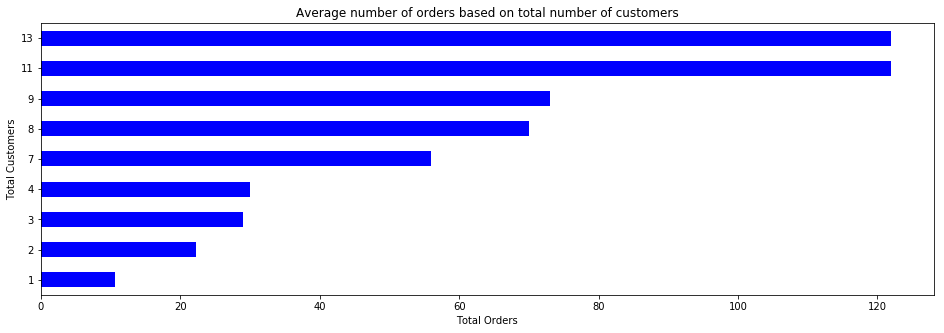

In [38]:
#Build a graph displaying Total customer averages vs. Total order averages
fig, ax = plt.subplots(1,1,figsize=(16,5)) 
y_ticks_labels = [1, 2, 3, 4, 7,8,9,11,13]
df3.groupby(['Total_Customers'])['Total_Orders'].mean().plot(kind='barh', color=['blue'])
ax.set_ylabel('Total Customers')
ax.set_xlabel('Total Orders')
ax.set_title('Average number of orders based on total number of customers')
ax.set_yticklabels([1, 2, 3, 4, 7,8,9,11,13])
fig.subplots_adjust(hspace=0.5);

### Welch's T- Test

In [39]:
welch_t(df3['Total_Customers'],df3['Total_Orders'])


4.628611685644748

In [40]:
welch_df(df3['Total_Customers'],df3['Total_Orders'])

20.427388264021292

In [41]:
t_3 = welch_t(df3['Total_Customers'],df3['Total_Orders'])
df_t3 = welch_df(df3['Total_Customers'],df3['Total_Orders'])
print(t_3,df_t3)

4.628611685644748 20.427388264021292


In [42]:
p = 1 - stats.t.cdf(t_3, df_t3)
print(p)

7.716295694659703e-05


Result: We can reject the null hypothesis as the p-value is less than a = .05. The number of customers in a country has a direct affect on the total number of orders from that country

Business Reccomendation: Focus on volume. Account management and enterprise customers aren't the bread and buttet 